In [1]:
import skysurvey
import matplotlib.pyplot as plt
import numpy as np
import sncosmo

In [2]:
snia = skysurvey.SNeIa()

In [3]:
data = snia.draw(size=10_000, inplace=True)

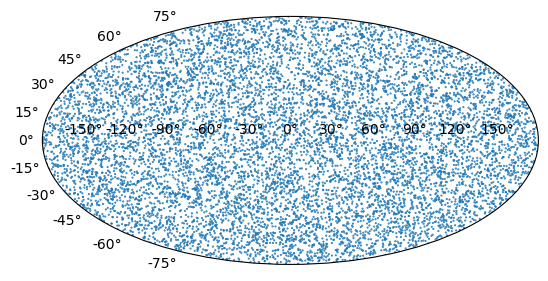

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (snia.data["ra"] - 360 * (snia.data["ra"] > 180)) * np.pi / 180,
    snia.data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

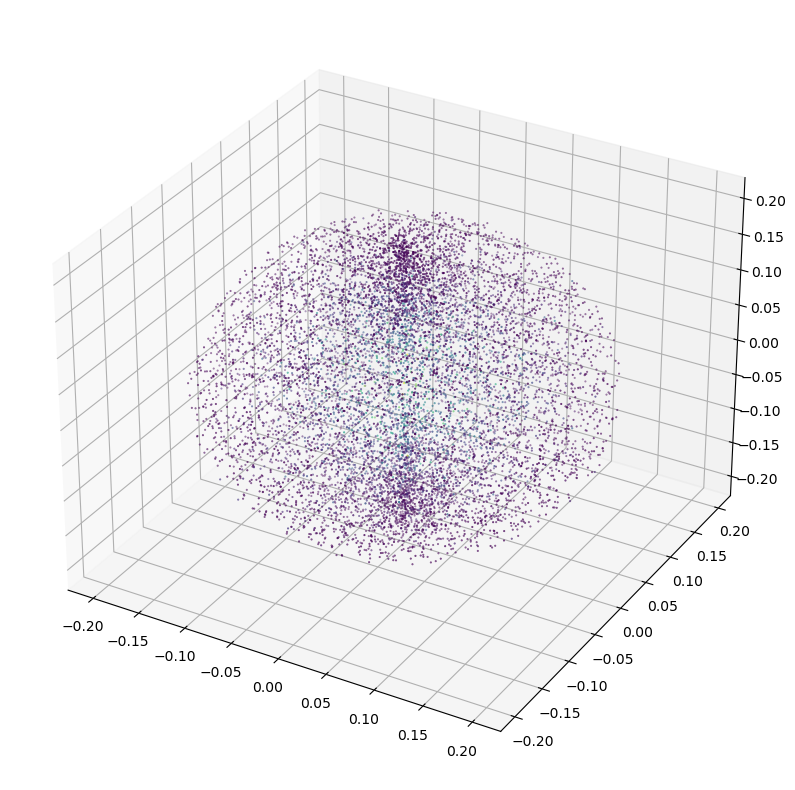

In [5]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

count, bin = np.histogramdd([snia.data["ra"], snia.data["dec"], snia.data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [snia.data["ra"] - binra.min(), snia.data["dec"] - bindec.min(), snia.data["z"] - binz.min()]
).T


def density_posterior(
    candidates: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    dist_id, nn_id = tree.query(candidates, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_posterior(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.sin(snia.data["ra"]) * np.sin(snia.data["dec"]) * snia.data["z"],
    np.cos(snia.data["dec"]) * snia.data["z"],
    s=1,
    c=c,
    marker=".",
)

Text(0.5, 0.98, 'Distribution des SN')

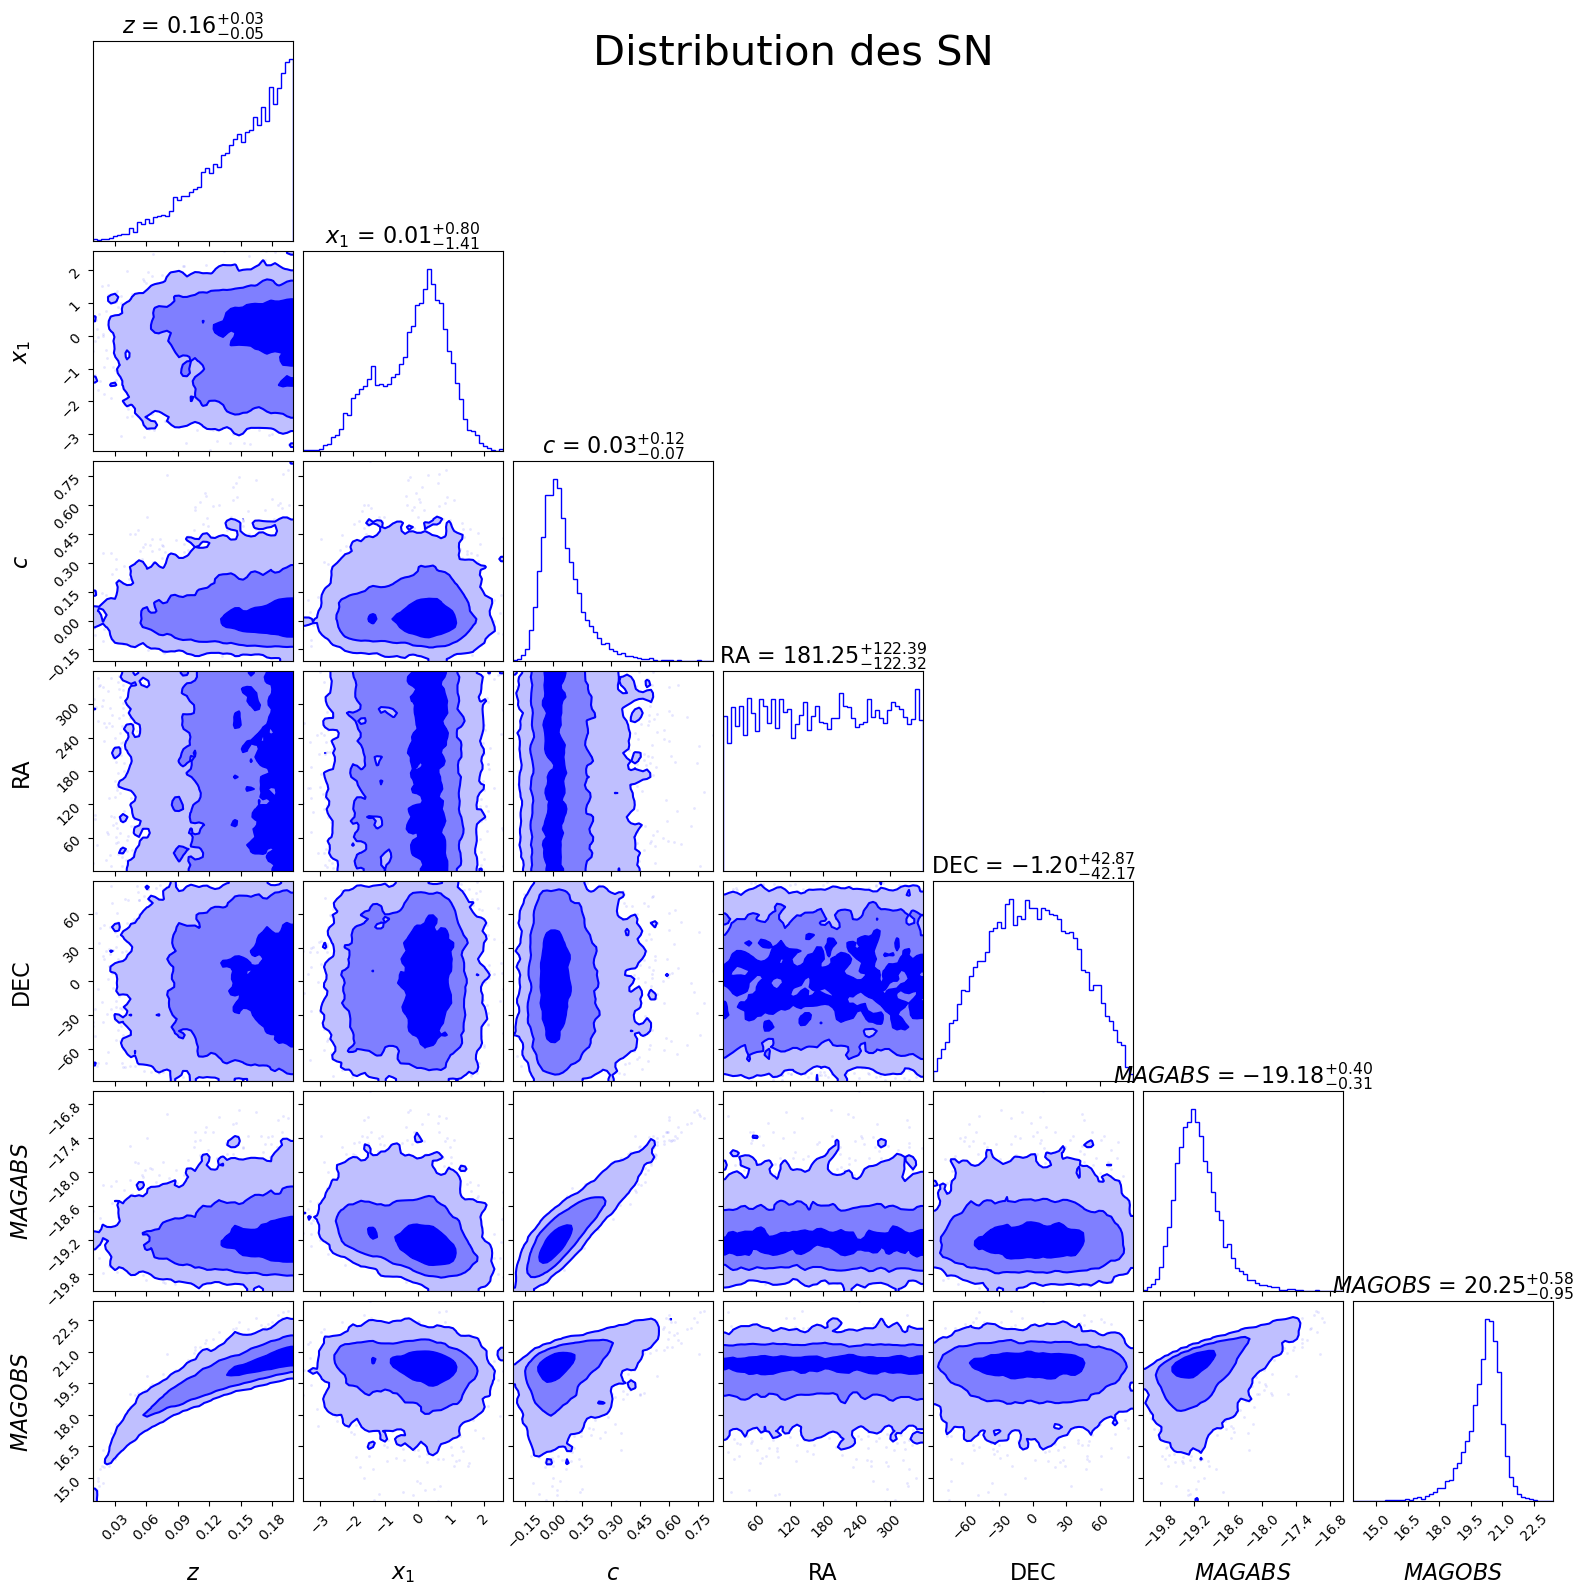

In [6]:
from turtle import title
import corner

fig = corner.corner(
    snia.data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=50,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$MAGABS$", r"$MAGOBS$"],
    alpha=0.2,
)

fig.suptitle('Distribution des SN', fontsize=30)

In [7]:
data[data["magobs"] == data["magobs"].max()]

,z,x1,c,t0,ra,dec,magabs,mwebv,magobs,x0,template
8838,0.19685,-1.48,0.829,56013.859375,245.503723,9.346498,-16.569016,0.067828,23.419096,0.000007,salt2


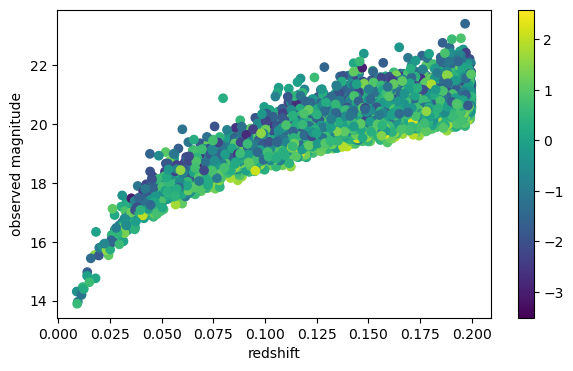

In [8]:
fig = snia.show_scatter("z", "magobs", ckey="x1")
ax = fig.axes[0]

_ = ax.set_ylabel("observed magnitude")
_ = ax.set_xlabel("redshift")

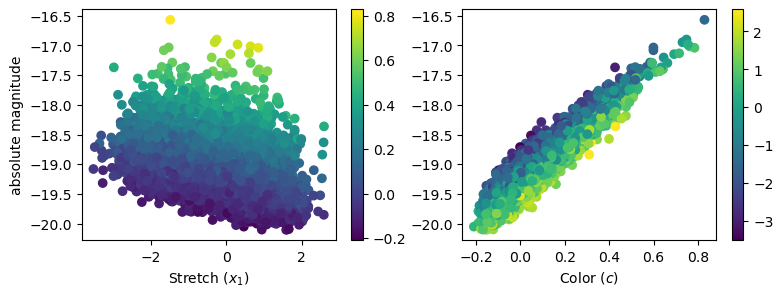

In [9]:
fig = plt.figure(figsize=[9, 3])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

_ = snia.show_scatter("x1", "magabs", ckey="c", ax=ax1)
_ = snia.show_scatter("c", "magabs", ckey="x1", ax=ax2)

_ = ax1.set_ylabel("absolute magnitude")
_ = ax1.set_xlabel(rf"Stretch ($x_1$)")
_ = ax2.set_xlabel(rf"Color ($c$)")

In [12]:
# footprint
from shapely import geometry

footprint = geometry.Point(0, 0).buffer(2)

# observing logs
import numpy as np
from skysurvey.tools import utils

size = 10_000

data = {}
data["gain"] = 1
data["zp"] = 30
data["skynoise"] = np.random.normal(size=size, loc=200, scale=20)
data["mjd"] = np.random.uniform(56_000, 56_200, size=size)
data["band"] = np.random.choice(["ztfg", "ztfr", "ztfi"], size=size)

data["ra"], data["dec"] = utils.random_radec(
    size=size, ra_range=[200, 250], dec_range=[-20, 10]
)

# Load a GridSurvey
survey = skysurvey.Survey.from_pointings(data, footprint=footprint)

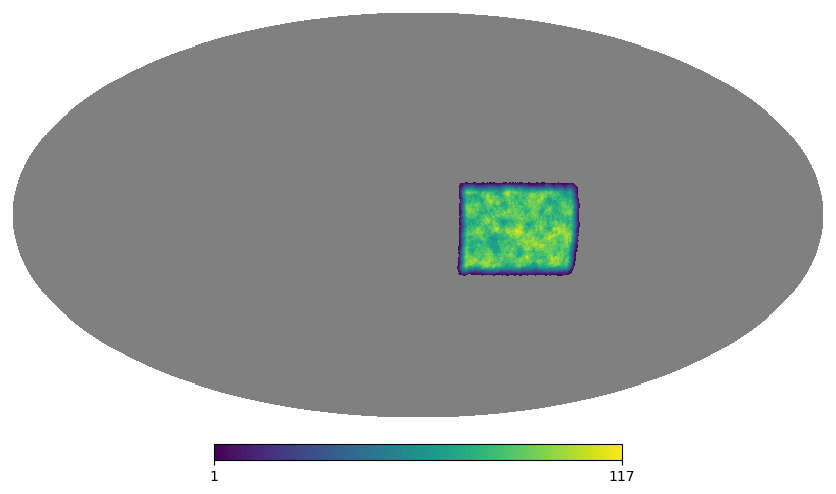

In [13]:
survey.show()

In [14]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey)

In [15]:
dataset = dset.get_ndetection()
detected = dataset[dataset > 5].index

In [16]:
len(detected)

382

Text(0.5, 0.98, 'Distribution des SN détectées')

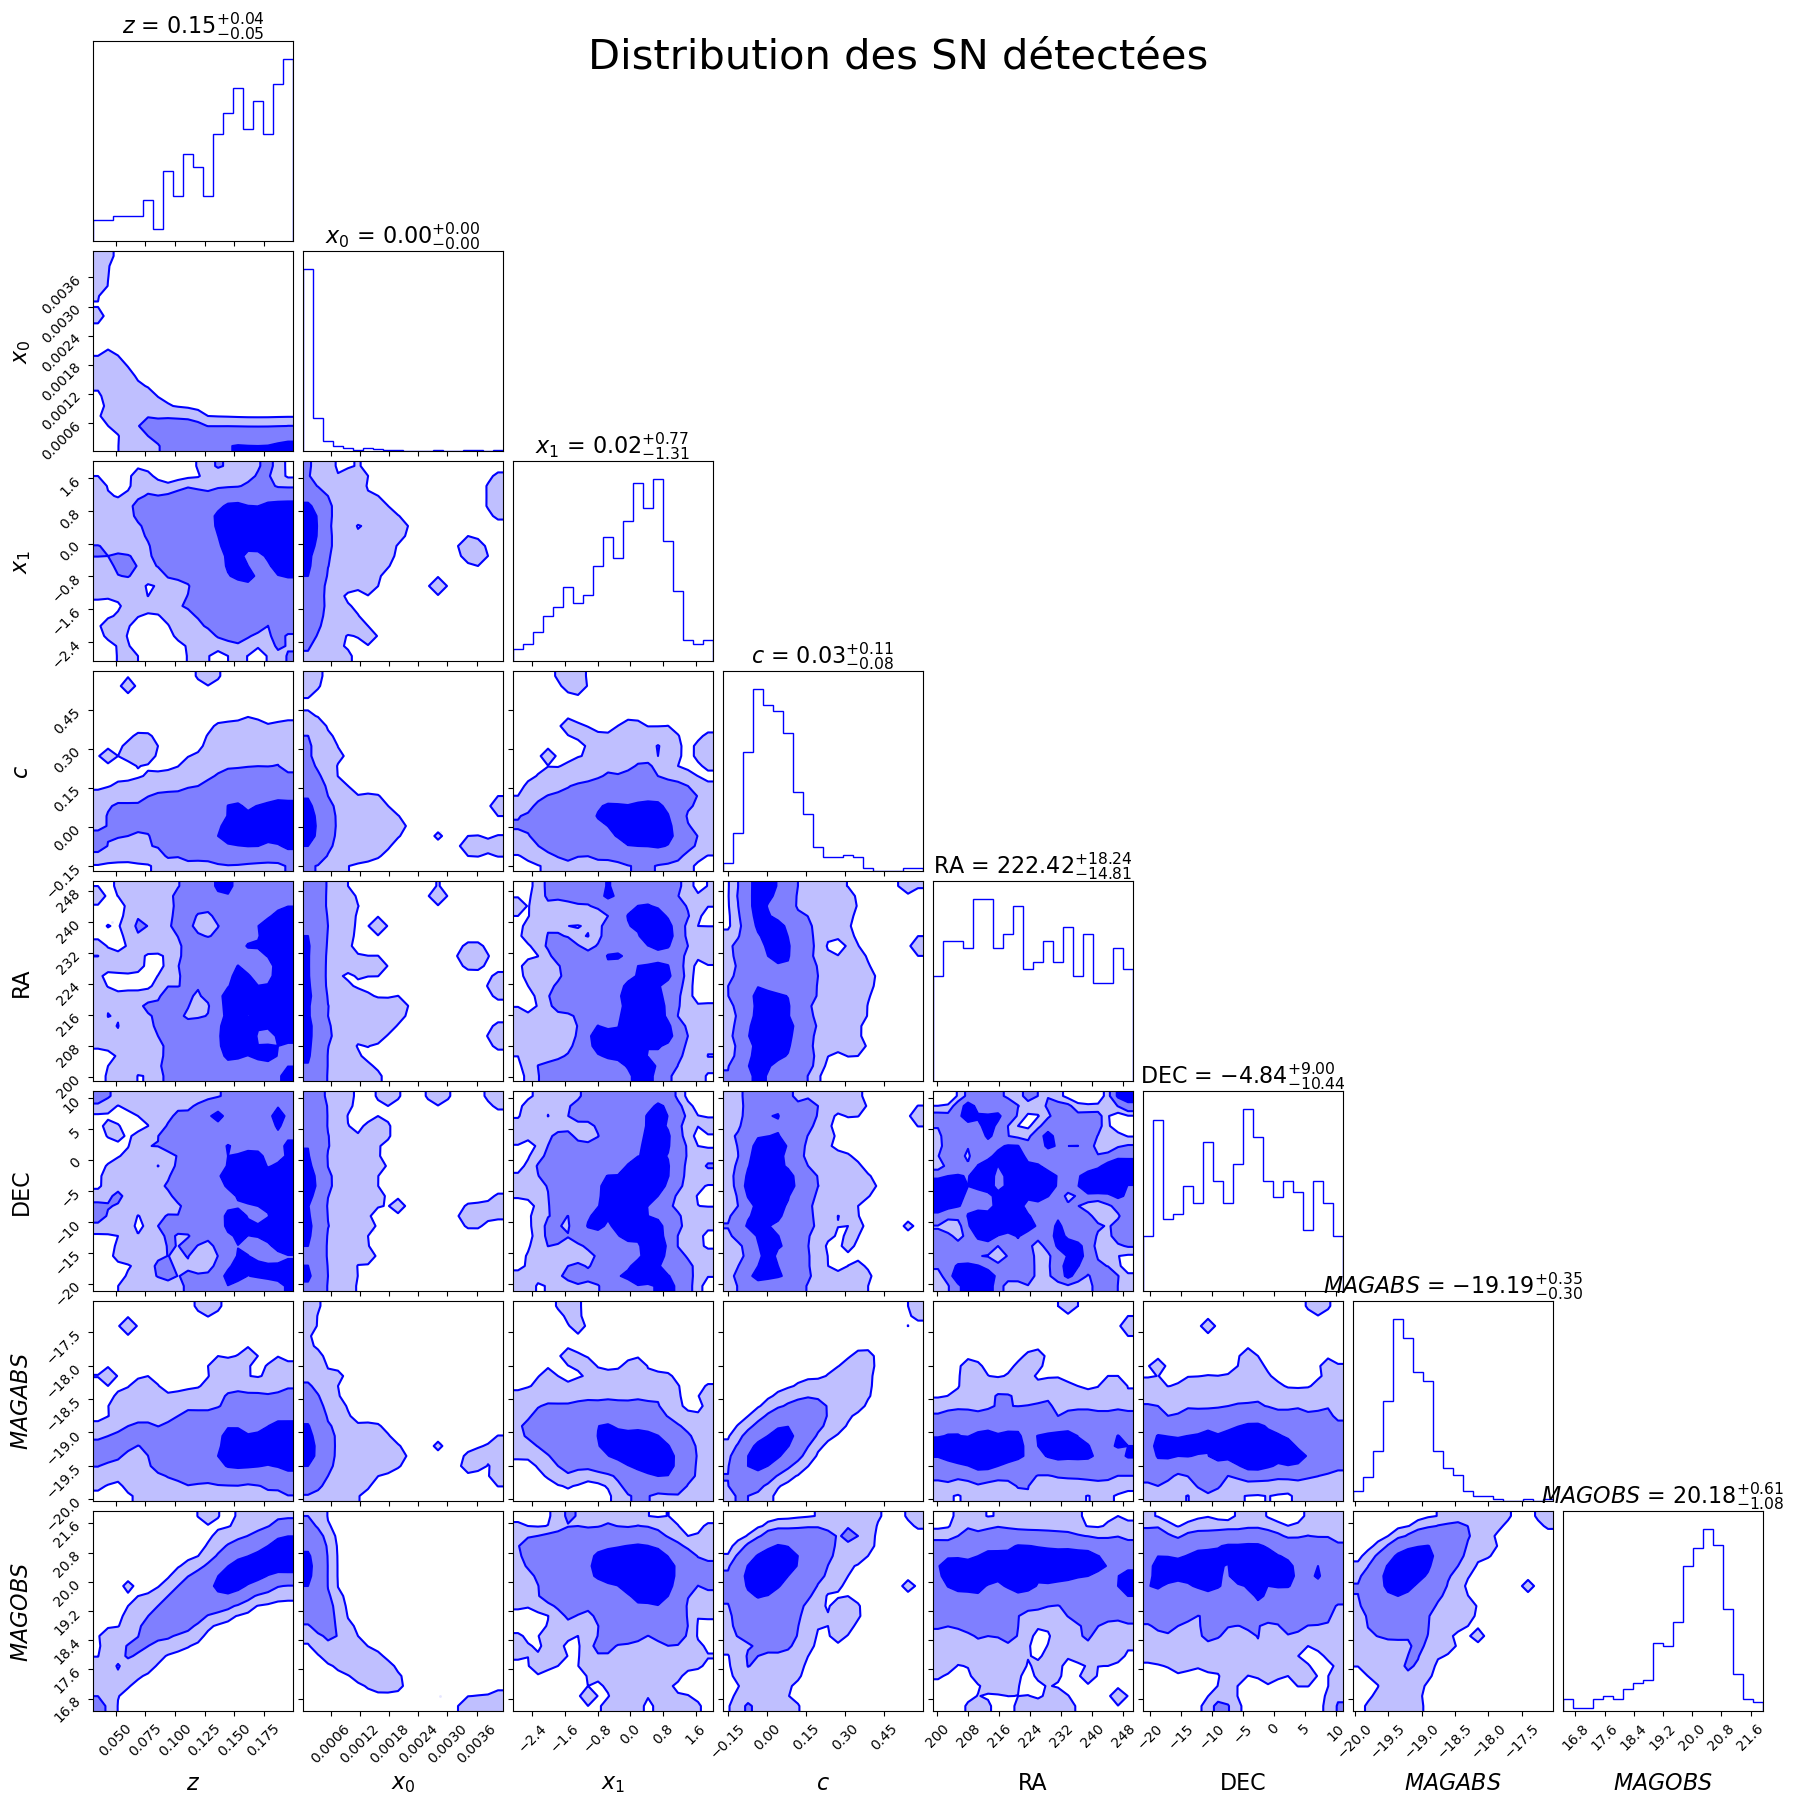

In [17]:
fig = corner.corner(
    dset.targets.data.loc[detected],
    var_names=["z", "x0", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=20,
    smooth=0.9,
    quantiles=None,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[
        r"$z$",
        r"$x_0$",
        r"$x_1$",
        r"$c$",
        r"RA",
        r"DEC",
        r"$MAGABS$",
        r"$MAGOBS$",
    ],
    alpha=0.2,
)
fig.suptitle('Distribution des SN détectées', fontsize=30)

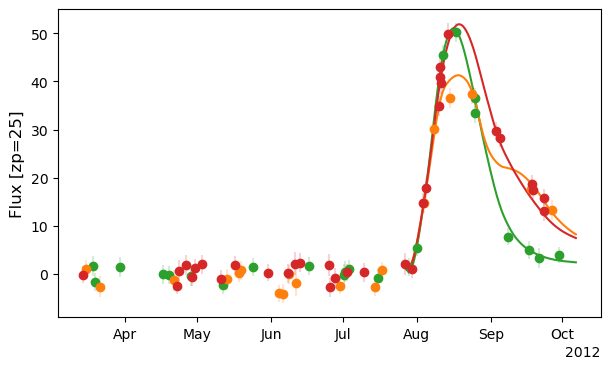

In [18]:
_ = dset.show_target_lightcurve(index=detected[212])

In [19]:
fixed = {"z": dset.targets.data.loc[detected]["z"]}

guess = {
    "t0": dset.targets.data.loc[detected]["t0"],
    "c": dset.targets.data.loc[detected]["c"],
    "x0": dset.targets.data.loc[detected]["x0"],
    "x1": dset.targets.data.loc[detected]["x1"],
}
bounds = {
    "t0": dset.targets.data.loc[detected]["t0"].apply(lambda x: [x-5, x+5]),
    "c": dset.targets.data.loc[detected]["c"].apply(lambda x: [-0.3, 1.0]),
    "x0": dset.targets.data.loc[detected]["x0"].apply(lambda x: [0, 0.1]),
    "x1": dset.targets.data.loc[detected]["x1"].apply(lambda x: [-4, 4]),
}

results, meta = dset.fit_lightcurves(
    source=sncosmo.Model("salt2"),
    index=detected,
    use_dask=False,
    fixedparams=fixed,
    guessparams=guess,
    bounds=bounds,
)

/home/antoine/anaconda3/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/antoine/anaconda3/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/antoine/anaconda3/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/antoine/anaconda3/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/antoine/anaconda3/lib/python3.10/site-packages/iminuit/util.py:172: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/antoine/anaconda3/lib/python3.10/site-packag

In [20]:
results

value     error        cov_t0        cov_x0        cov_x1  \
index                                                                        
1     z       0.108650       NaN           NaN           NaN           NaN   
      t0  56101.370356  0.039783  1.582710e-03 -4.680036e-08  3.249572e-04   
      x0      0.000581  0.000004 -4.680036e-08  1.369759e-11 -1.198914e-07   
      x1      1.309537  0.047900  3.249572e-04 -1.198914e-07  2.294558e-03   
      c      -0.179126  0.005114  4.608503e-05 -1.649723e-08  1.177970e-04   
...                ...       ...           ...           ...           ...   
9962  z       0.129150       NaN           NaN           NaN           NaN   
      t0  56076.841373  0.130587  1.705677e-02  2.179680e-07 -1.022777e-02   
      x0      0.000288  0.000003  2.179680e-07  9.001821e-12 -2.942211e-07   
      x1      0.750469  0.123691 -1.022777e-02 -2.942211e-07  1.530441e-02   
      c      -0.081700  0.008566 -5.413848e-04 -1.960355e-08  5.351149e-04   

                 cov_c         truth  
index                                 
1     z            NaN       0.10865  
      t0  4.608503e-05  56101.445312  
      x0 -1.649723e-08      0.000576  
      x1  1.177970e-04          1.27  
      c   2.615282e-05        -0.168  
...                ...           ...  
9962  z            NaN       0.12915  
      t0 -5.413848e-04  56076.707031  
      x0 -1.960355e-08      0.000287  
      x1  5.351149e-04          0.95  
      c   7.338920e-05        -0.083  

[1910 rows x 7 columns]

In [21]:
import pandas

better_results = pandas.DataFrame(
    {
        col: np.array(results["value"].loc[map(lambda x: (x, col), detected)]-results["truth"].loc[map(lambda x: (x, col), detected)])
        for col in guess.keys()
    }
)

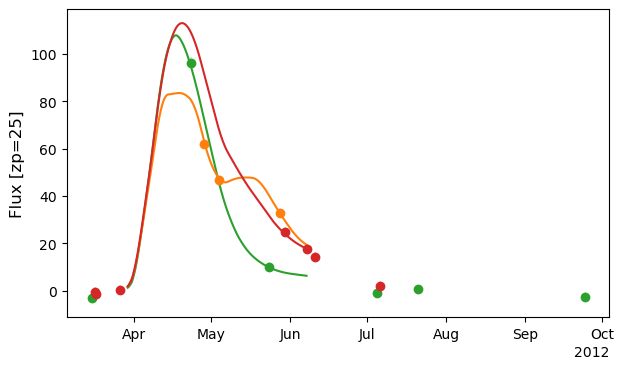

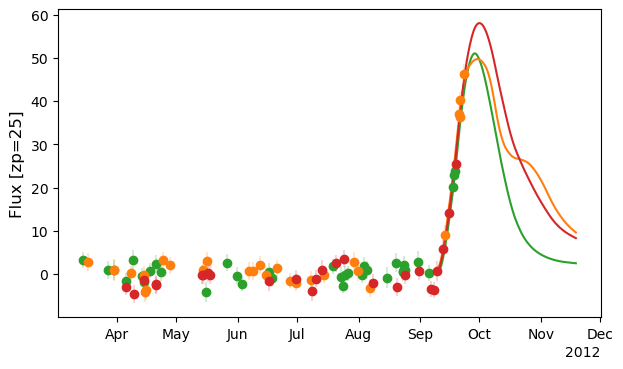

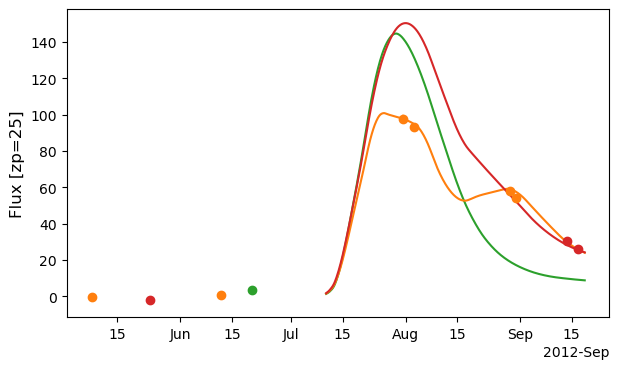

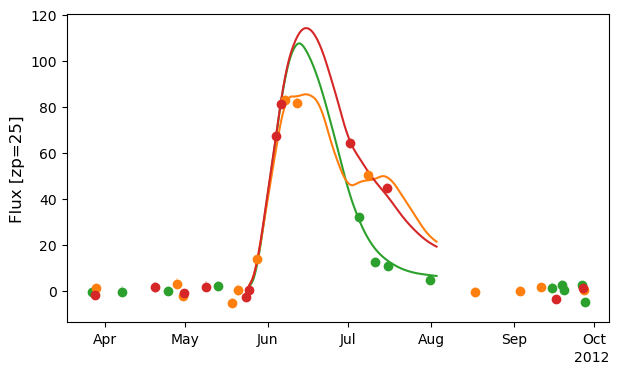

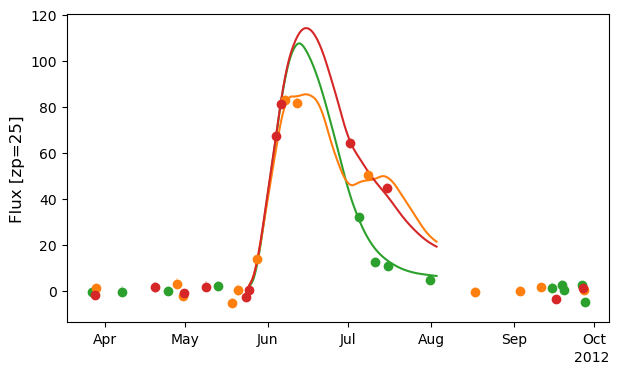

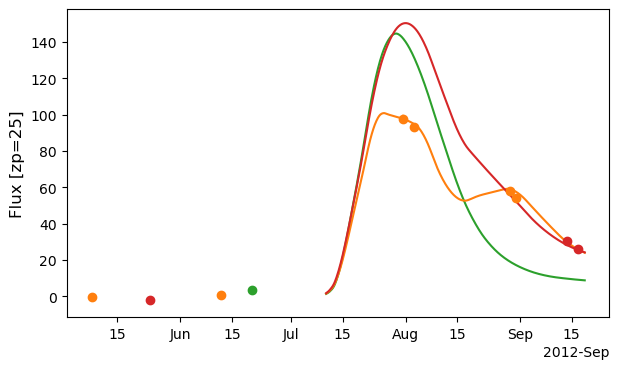

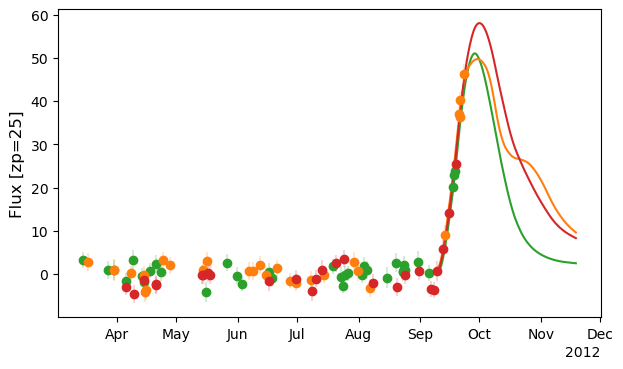

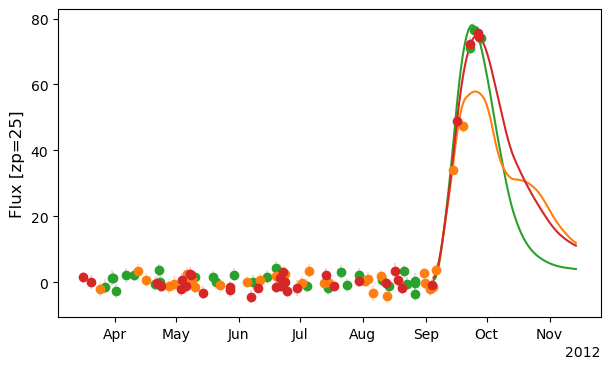

In [22]:
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].max()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["t0"]==better_results['t0'].min()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["c"]==better_results['c'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x0"]==better_results['x0'].max()].index[0]])

_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].min()].index[0]])
_ = dset.show_target_lightcurve(index=detected[better_results[better_results["x1"]==better_results['x1'].max()].index[0]])

Text(0.5, 0.98, 'Erreur absolue sur les paramètres reconstruits')

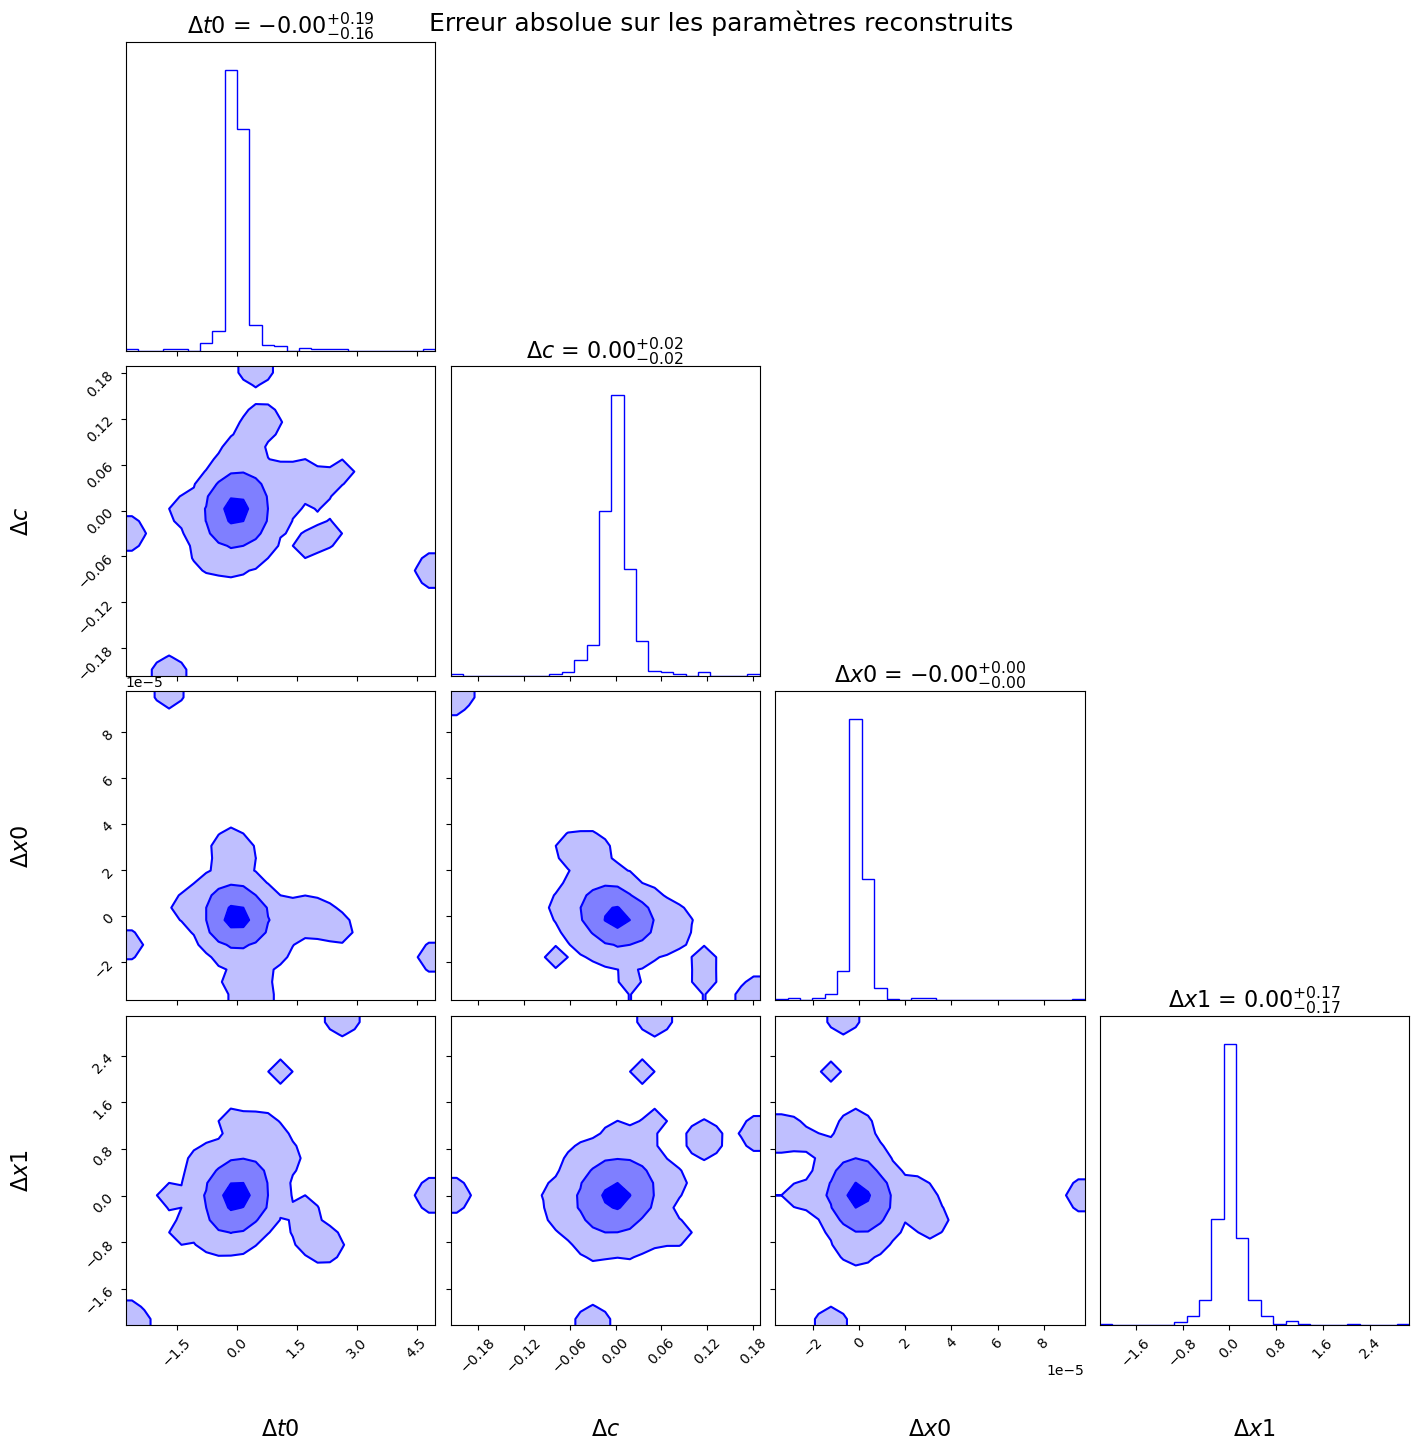

In [24]:
fig = plt.figure(figsize=(15,15))
_ = corner.corner(
    better_results,
    fig=fig,
    var_names=list(guess.keys()),
    show_titles=True,
    bins=25,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=list(map(lambda x : r"$\Delta "+x+r"$", guess.keys())),
    alpha=0.2,
)
fig.suptitle('Erreur absolue sur les paramètres reconstruits', fontsize=18)